In [29]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint as r
import random

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deparma","key":"9b5afe96f2fa1b3d0685ab9435d14647"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
# !kaggle datasets list

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:10<00:00, 157MB/s]
100% 1.33G/1.33G [00:10<00:00, 140MB/s]


In [7]:
!unzip -q celeba-dataset.zip
!ls

celeba-dataset.zip  list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba    list_bbox_celeba.csv     sample_data
kaggle.json	    list_eval_partition.csv


In [9]:
from glob import glob

In [11]:
names = glob('/content/img_align_celeba/img_align_celeba/*.jpg')

In [88]:
def img_preprocess():
    i=0
    img_list = []
    while i<1000:
        img_path = names[i]
        img = cv.imread(img_path)            #cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB / cv 3-dim，last_channel = 3，RGB
        img = cv.resize(img, (64, 64))     #преобразование формы в (224, 224) / shape (224, 224)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        sc_img = img.astype('float') / 255   #нормализация / normalization
        img_list.append(sc_img)
        i=i+1
    return np.asarray(img_list)

In [89]:
import cv2 as cv

In [90]:
img_arr = img_preprocess()

([], <a list of 0 Text major ticklabel objects>)

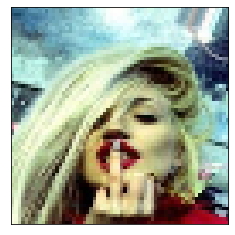

In [91]:
plt.imshow(img_arr[43])
plt.xticks([])
plt.yticks([])

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
x_train, x_test = train_test_split(img_arr, test_size=0.3, random_state=0)

In [94]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [112]:
# network parameters
input_shape = (x_train.shape[1], x_train.shape[2], 1)
filters = 60
latent_dim = 2


inputs = Input(shape=input_shape, name='encoder_input')

x = inputs

for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)
    filters *= 2

shape = K.int_shape(x)

x = Flatten()(x)

In [113]:
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')

vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))

vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 32, 32, 60)   600         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 16, 16, 120)  64920       conv2d_73[0][0]                  
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 30720)        0           conv2d_74[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [114]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [115]:
# vae.fit(
#     x_train.reshape(-1,28,28,1),
#     x_train.reshape(-1,28,28,1),
#     epochs=10,
#     batch_size=128,
#     validation_data=(x_test.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1)),
#     # callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, restore_best_weights=True)]
# )

In [116]:
pic_size = 64

In [117]:
def create_VAE(input_shape):
    #CREATING THE VAE NETWORK
    image_size = input_shape[1]
    original_dim = image_size * image_size
    inputs = Input(shape=input_shape)
    print(inputs.shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    print(x.shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    print(x.shape)
    x = Dropout(0.2)(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    print(x.shape)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    print(x.shape)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    print(x.shape)
    x = Dense(pic_size, activation='relu')(x)
    print(x.shape)
    
    latent_dim = 20
    
    latent_mean = Dense(latent_dim)(x)
    print(latent_mean.shape)
    latent_log_variance = Dense(latent_dim)(x)
    print(latent_log_variance.shape)
    
    latent_sample = Lambda(sampling)([latent_mean, latent_log_variance])
    print(latent_sample.shape)
    
    #BUILDING THE ENCODER
    encoder = Model(inputs, [latent_mean, latent_log_variance, latent_sample])
    
    latent_inputs = Input(shape=(latent_dim,))
    print(latent_inputs.shape)
    x = Dense(8*8*pic_size, activation='relu')(latent_inputs)
    print(x.shape)
    x = Reshape((8,8,pic_size))(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    print(x.shape)
   
    # Outputs for the encoder by a sigmoid activation function
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    print(outputs.shape)
    
    #BUILDING THE DECODER
    decoder = Model(latent_inputs, outputs)
    
    # The outputs of the decoder are taken as the inputs of the encoder
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs)
    
    # The losses of the VAE model is taken as the sum of the (binary cross entropy *dimensions) and the kl divergence loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * original_dim
    reconstruction_loss = K.mean(reconstruction_loss)
    print(reconstruction_loss)
    
    kl_loss = 1 + latent_log_variance - K.square(latent_mean) - K.exp(latent_log_variance)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    print(kl_loss)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    print(vae_loss)
    vae.add_loss(vae_loss)
    return vae, encoder, decoder

In [118]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 188404      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 64, 64, 1)    287281      encoder[0][2]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 32, 32, 60)   600         encoder_input[0][0]              
________________________________________________________________________________________________

In [119]:
vae, encoder, decoder = create_VAE(input_shape=(pic_size,pic_size,3))
vae.compile(optimizer='adam', metrics=['accuracy'])

(None, 64, 64, 3)
(None, 64, 64, 32)
(None, 64, 64, 32)
(None, 32, 32, 32)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 16, 16, 64)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 8, 8, 128)
(None, 8192)
(None, 64)
(None, 20)
(None, 20)
(None, 20)
(None, 20)
(None, 4096)
(None, 8, 8, 64)
(None, 16, 16, 64)
(None, 16, 16, 256)
(None, 16, 16, 256)
(None, 32, 32, 256)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 3)
KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_20/Mean:0', description="created by layer 'tf.math.reduce_mean_20'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.multiply_17/Mul:0', description="created by layer 'tf.math.multiply_17'")
KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_21/Mean:0', description="created by layer 'tf.math.reduce_mean_21'")


In [131]:
vae.fit(x_test,x_test,batch_size = 5,epochs = 700)

Epoch 1/700
60/60 [==============================] - 1s 14ms/step - loss: 1980.0157 - accuracy: 0.8201
Epoch 2/700
60/60 [==============================] - 1s 13ms/step - loss: 1977.7421 - accuracy: 0.8213
Epoch 3/700
60/60 [==============================] - 1s 13ms/step - loss: 1978.3977 - accuracy: 0.8160
Epoch 4/700
60/60 [==============================] - 1s 13ms/step - loss: 1978.7478 - accuracy: 0.8200
Epoch 5/700
60/60 [==============================] - 1s 13ms/step - loss: 1977.5631 - accuracy: 0.8202
Epoch 6/700
60/60 [==============================] - 1s 13ms/step - loss: 1978.7871 - accuracy: 0.8155
Epoch 7/700
60/60 [==============================] - 1s 13ms/step - loss: 1979.2109 - accuracy: 0.8174
Epoch 8/700
60/60 [==============================] - 1s 13ms/step - loss: 1977.6085 - accuracy: 0.8173
Epoch 9/700
60/60 [==============================] - 1s 13ms/step - loss: 1977.0879 - accuracy: 0.8188
Epoch 10/700
60/60 [==============================] - 1s 13ms/step - loss

In [132]:
pred = vae.predict(x_test)

88


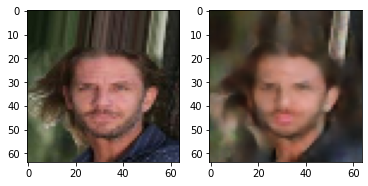

In [133]:
temp = r(0,300)
print(temp)
plt.subplot(1,2,1)
plt.imshow(x_test[temp])
plt.subplot(1,2,2)
plt.imshow(pred[temp])

In [134]:
test_rec = vae.predict(x_test)

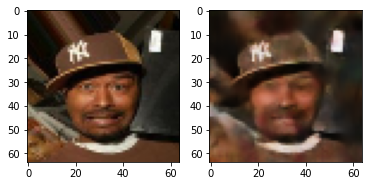

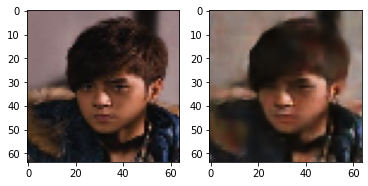

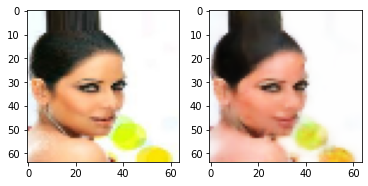

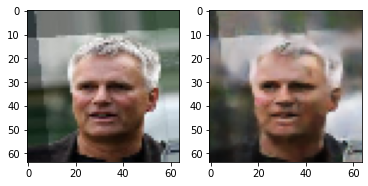

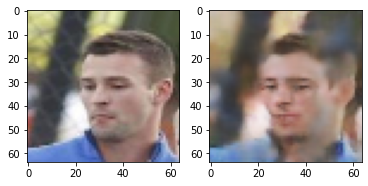

In [135]:
for i in range(5):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(x_test[i], vmin=0, vmax=1)
    # plt.show()
    # plt.figure(figsize=(1,1))
    ax[1].imshow(test_rec[i], vmin=0, vmax=1)
    # plt.show()